<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/Feature_Explainability_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brain Tumor Dataset<br>
source: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset<br>
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']<br>
number of training MRIs slices = 5712 <br>
number of testing MRIs slices = 1311 <br>

Download the dataset:

In [1]:
import gdown

url = 'https://drive.google.com/uc?id=1Oms9X0Vpid_kN8jiSgz-3MhRA5BcmivE'
gdown.download(url,'braintumor.zip',quiet=True)
!unzip -q braintumor.zip -d braintumor

Download my trained weights:

In [2]:
import gdown

!mkdir myweights

#ResNet34
url = 'https://drive.google.com/uc?id=19GYVgCz9wjO4wdCmFWhUw9_Uylzylfqe'
gdown.download(url,'myweights/best_model.pth.tar',quiet=True)

#DesnseNet121
url = 'https://drive.google.com/uc?id=1RQHQiF9LrRKbIUSaCOZd8-9paio6DFZ8'
gdown.download(url,'myweights/best_model_densenet8.pth.tar',quiet=True)

'myweights/best_model_densenet8.pth.tar'

In [8]:
#ViT
url = 'https://drive.google.com/uc?id=1yYBUwjxmrjQevBPleZAQeEyHR-Pq5wWB'
gdown.download(url,'myweights/best_model_vit.pth.tar',quiet=True)

'myweights/best_model_vit.pth.tar'

Sample Data:

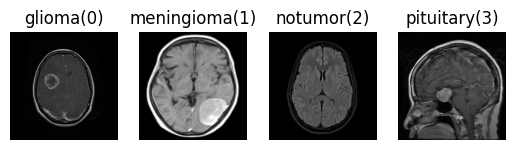

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

class_names = ['glioma(0)', 'meningioma(1)', 'notumor(2)', 'pituitary(3)']

newsize = (224, 224)
img_glioma = Image.open('/content/braintumor/Testing/glioma/Te-gl_0014.jpg').resize(newsize)
img_meningioma = Image.open('/content/braintumor/Testing/meningioma/Te-me_0017.jpg').resize(newsize)
img_healthy = Image.open('/content/braintumor/Testing/notumor/Te-noTr_0002.jpg').resize(newsize)
img_pituitary = Image.open('/content/braintumor/Testing/pituitary/Te-piTr_0008.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

#Explainability with of penultimate layer features
ResNet34:

In [4]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
    my_transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
        ])

    test_dataset = datasets.ImageFolder(root='/content/braintumor/Testing', transform=my_transform)
    testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

    model = models.resnet34()
    model.fc = nn.Linear(model.fc.in_features, 4)
    model.to(device)
    model.load_state_dict(torch.load('myweights/best_model.pth.tar'))
    model.eval()
    accuracy = test(model, testloader)

    print('Model Accuracy:{:.2f}%'.format(accuracy*100,2))


Model Accuracy:98.78%


#t-SNE to explain the ResNet34 feature representation

Pred shape : (1311, 512)
Target shape : (1311,)


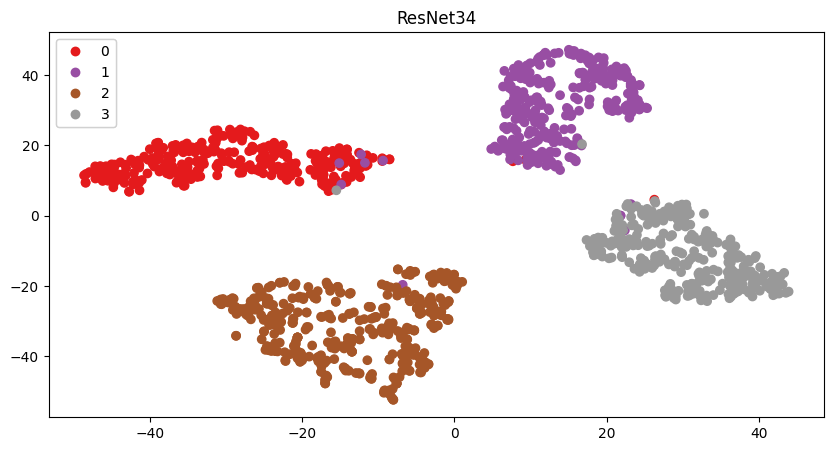

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def get_features(model, testloader):
    model.eval()
    out_targets = []
    out_features = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets
            feature = model(inputs)
            out_features.extend(feature.detach().cpu().numpy())
            out_targets.extend(targets.cpu().numpy())

    return np.array(out_features), np.array(out_targets)

model = models.resnet34()
model.fc = nn.Linear(model.fc.in_features, 4)
model.to(device)
model.load_state_dict(torch.load('myweights/best_model.pth.tar'))
model.fc = nn.Flatten()
model.to(device)

out_features, out_targets = get_features(model, testloader)

print('Pred shape :',out_features.shape)
print('Target shape :',out_targets.shape)

tsne = TSNE(n_components=2, init='pca', random_state=0)
output_array = tsne.fit_transform(out_features)
plt.rcParams['figure.figsize'] = 10,5

fig, ax = plt.subplots()
scatter = ax.scatter(output_array[:,0], output_array[:,1], c=out_targets, cmap='Set1')
legend = ax.legend(*scatter.legend_elements(),loc="upper left")
ax.add_artist(legend)
plt.title('ResNet34')
plt.show()
plt.close()

#DesnseNet Accuracy:

In [6]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
    my_transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
        ])

    test_dataset = datasets.ImageFolder(root='/content/braintumor/Testing', transform=my_transform)
    testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

    model = models.densenet121()
    model.classifier = nn.Linear(model.classifier.in_features, 4)
    model.to(device)
    model.load_state_dict(torch.load('myweights/best_model_densenet8.pth.tar'))
    model.eval()
    accuracy = test(model, testloader)

    print('Model Accuracy:{:.2f}%'.format(accuracy*100,2))


Model Accuracy:98.47%


#t-SNE to explain the DesNet121 feature representation

Feature shape : (1311, 1024)
Target shape : (1311,)


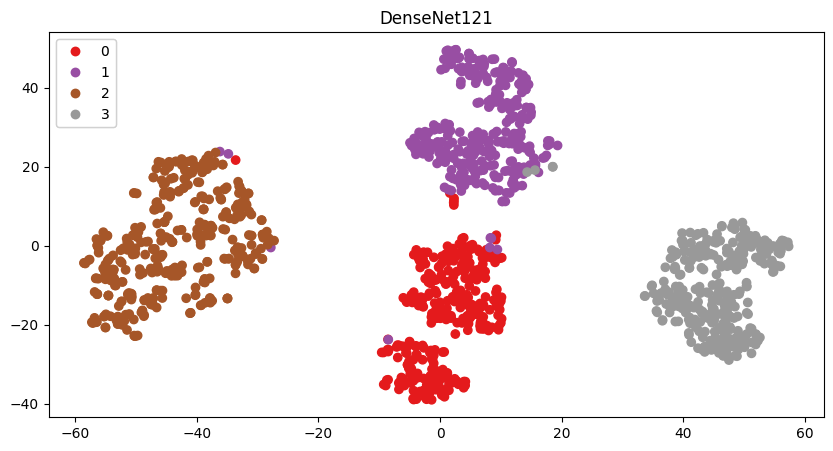

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def get_features(model, testloader):
    model.eval()
    out_targets = []
    out_features = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets
            feature = model(inputs)
            out_features.extend(feature.detach().cpu().numpy())
            out_targets.extend(targets.cpu().numpy())

    return np.array(out_features), np.array(out_targets)

model = models.densenet121()
model.classifier = nn.Linear(model.classifier.in_features, 4)
model.to(device)
model.load_state_dict(torch.load('myweights/best_model_densenet8.pth.tar'))
model.classifier = nn.Flatten()
model.to(device)

out_features, out_targets = get_features(model, testloader)

print('Feature shape :',out_features.shape)
print('Target shape :',out_targets.shape)

tsne = TSNE(n_components=2, init='pca', random_state=0)
output_array = tsne.fit_transform(out_features)
plt.rcParams['figure.figsize'] = 10,5

fig, ax = plt.subplots()
scatter = ax.scatter(output_array[:,0], output_array[:,1], c=out_targets, cmap='Set1')
legend = ax.legend(*scatter.legend_elements(),loc="upper left")
ax.add_artist(legend)
plt.title('DenseNet121')
plt.show()
plt.close()

#Feature Explainability with Vision Transformer (ViT)

In [10]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
    my_transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
        ])

    test_dataset = datasets.ImageFolder(root='/content/braintumor/Testing', transform=my_transform)
    testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

    model = models.vision_transformer.vit_b_32()
    model.heads = nn.Linear(model.heads[0].in_features, 4)
    model.to(device)
    model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar'))
    model.eval()
    accuracy = test(model, testloader)

    print('Model Accuracy:{:.2f}%'.format(accuracy*100,2))


Model Accuracy:98.17%


#t-SNE to explain the ViT feature representation

Feature shape : (1311, 768)
Target shape : (1311,)


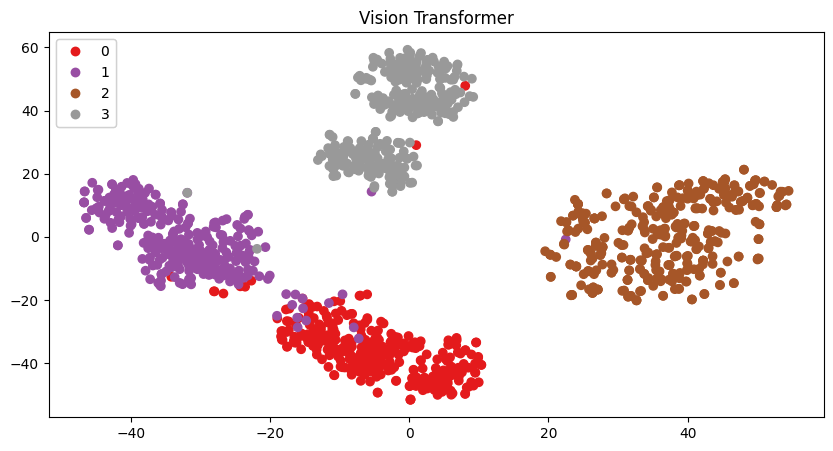

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def get_features(model, testloader):
    model.eval()
    out_targets = []
    out_features = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets
            feature = model(inputs)
            out_features.extend(feature.detach().cpu().numpy())
            out_targets.extend(targets.cpu().numpy())

    return np.array(out_features), np.array(out_targets)

model = models.vision_transformer.vit_b_32()
model.heads = nn.Linear(model.heads[0].in_features, 4)
model.to(device)
model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar'))
model.heads = nn.Flatten()
model.to(device)

out_features, out_targets = get_features(model, testloader)

print('Feature shape :',out_features.shape)
print('Target shape :',out_targets.shape)

tsne = TSNE(n_components=2, init='pca', random_state=0)
output_array = tsne.fit_transform(out_features)
plt.rcParams['figure.figsize'] = 10,5

fig, ax = plt.subplots()
scatter = ax.scatter(output_array[:,0], output_array[:,1], c=out_targets, cmap='Set1')
legend = ax.legend(*scatter.legend_elements(),loc="upper left")
ax.add_artist(legend)
plt.title('Vision Transformer')
plt.show()
plt.close()